In [7]:
import os, copy
import Ipynb_importer
import mask_out, mask_out2

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
import cartopy.io.shapereader as shpreader

import numpy as np
import xarray as xr

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as cor
import matplotlib.patches as mpatches
font_options = {'family': 'serif'}
plt.rc('font',**font_options)

In [3]:
# ----------- function: add compass -------------
def add_north(ax, labelsize=16, loc_x=0.07, loc_y=0.95, width=0.03, height=0.08, pad=0.14):
    """
draw a plotting scale with notation 'N', the main parameters are as follows:
    :param ax: the axes of the coordinate area to draw can be obtained by plt.gca()
    :param labelsize: displays the size of the 'n' text
    :param loc_x: the horizontal proportion of the whole ax centered at the lower part of the text
    :param loc_y: the vertical proportion of ax centered at the lower part of the text
    :param width: the width of the compass in ax ratio
    :param height: the height of compass in ax ratio
    :param pad: the gap of word symbols occupying the ax ratio
    :return: None
    """
    minx, maxx = ax.get_xlim()
    miny, maxy = ax.get_ylim()
    ylen = maxy - miny
    xlen = maxx - minx
    left = [minx + xlen*(loc_x - width*.5), miny + ylen*(loc_y - pad)]
    right = [minx + xlen*(loc_x + width*.5), miny + ylen*(loc_y - pad)]
    top = [minx + xlen*loc_x, miny + ylen*(loc_y - pad + height)]
    center = [minx + xlen*loc_x, left[1] + (top[1] - left[1])*.4]
    triangle = mpatches.Polygon([left, top, right, center], color='k')
    ax.text(s='N',
            x=minx + xlen*loc_x,
            y=miny + ylen*(loc_y - pad + height),
            fontsize=labelsize,
            horizontalalignment='center',
            verticalalignment='bottom')
    ax.add_patch(triangle)

# ----------- function: add plotting scale --------------
def add_scalebar(ax,lon0,lat0,length,size=0.45):
    '''
    :param ax: coordinate axis
    :param lon0: longitude
    :param lat0: latitude
    :param length: the length of the plotting scale
    :param size: controls thickness and distance of the plotting scale
    '''
    ax.hlines(y=lat0,  xmin = lon0, xmax = lon0+length/111, colors="black", ls="-", lw=1, label='%d km' % (length))
    ax.vlines(x = lon0, ymin = lat0-size, ymax = lat0+size, colors="black", ls="-", lw=1)
    ax.vlines(x = lon0+length/2/111, ymin = lat0-size, ymax = lat0+size, colors="black", ls="-", lw=1)
    ax.vlines(x = lon0+length/111, ymin = lat0-size, ymax = lat0+size, colors="black", ls="-", lw=1)
    ax.text(lon0+length/111,lat0+size+0.05,'%d' % (length),horizontalalignment = 'center')
    ax.text(lon0+length/2/111,lat0+size+0.05,'%d' % (length/2),horizontalalignment = 'center')
    ax.text(lon0,lat0+size+0.05,'0',horizontalalignment = 'center')
    ax.text(lon0+length/111/2*3,lat0+size+0.05,'km',horizontalalignment = 'center')

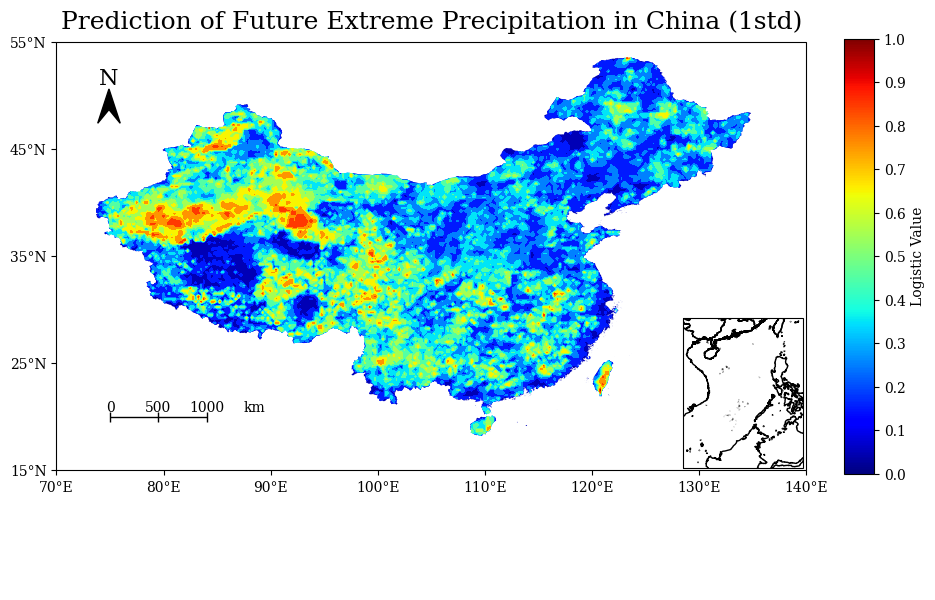

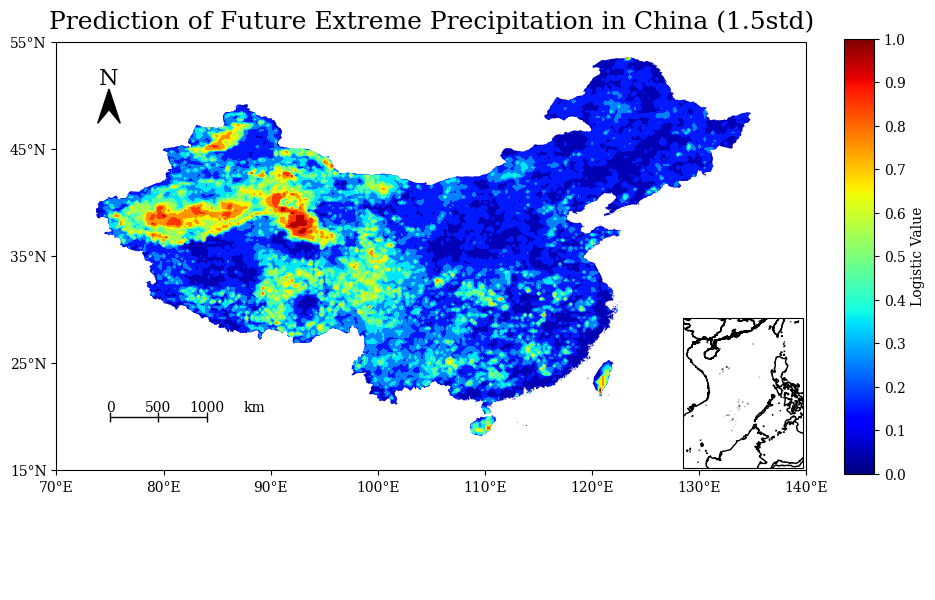

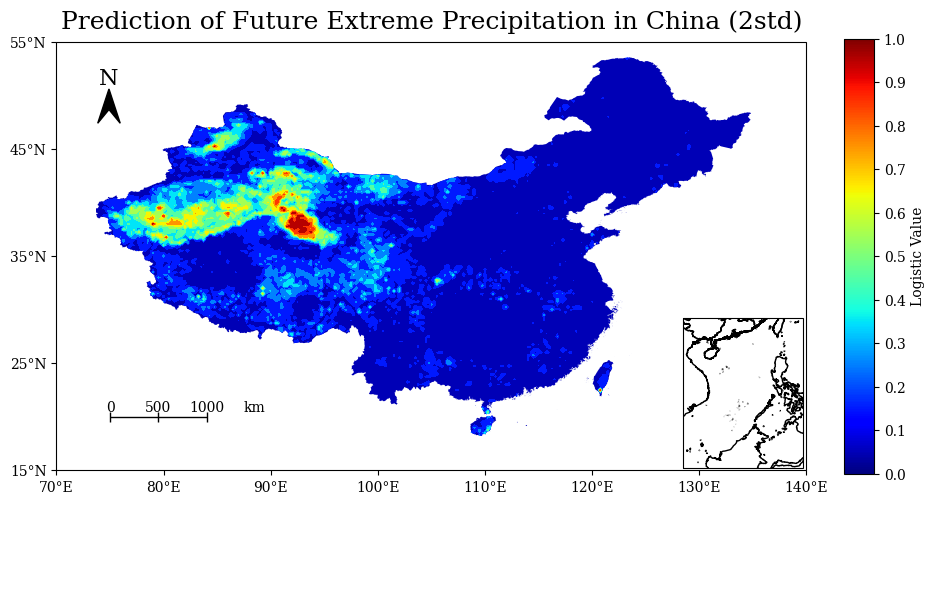

In [4]:
for i in [1,1.5,2]:
    file = xr.open_dataset('C:/Users/***/Desktop/I.E.doc/python/{}std_all.nc'.format(i)) 
    logistic_values = file.variables['1961-2019 logistic values']    
    data_var = np.nan_to_num(logistic_values)
    data_lat = file.variables['lat']
    data_lon = file.variables['lon']
    # create a canvas
    fig2 = plt.figure(figsize=(15,15))
    proj = ccrs.PlateCarree(central_longitude=105) 
    leftlon, rightlon, lowerlat, upperlat = (70,140,15,55)
    # plot the map
    f2_ax1 = fig2.add_axes([0.1, 0.1, 0.5, 0.3],projection = proj)
    # create a subplot in absolute coordinates on the canvas
    f2_ax1.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
    ## 10m accuracy coastline
    # f2_ax1.add_feature(cfeature.COASTLINE.with_scale('10m'))
    # define the geo-coordinate tag format
    f2_ax1.set_xticks(np.arange(leftlon,rightlon+10,10), crs=ccrs.PlateCarree())
    f2_ax1.set_yticks(np.arange(lowerlat,upperlat+10,10), crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    lat_formatter = cticker.LatitudeFormatter()
    f2_ax1.xaxis.set_major_formatter(lon_formatter)
    f2_ax1.yaxis.set_major_formatter(lat_formatter)
    f2_ax1.set_title('Prediction of Future Extreme Precipitation in China ({}std)'.format(i)
                     ,loc='center', pad=10, fontsize=18)
    # read the .shp file
    os.chdir(r'C:\Users\***\Desktop\i.e.re\shpfile\ProvincialBorder')
    china = shpreader.Reader('bou2_4p.dbf').geometries()
    # add the south China sea in the bottom right corner of the subplot
    f2_ax2 = fig2.add_axes([0.5175, 0.0935, 0.08, 0.13],projection = proj)
    f2_ax2.set_extent([105, 125, 0, 25], crs=ccrs.PlateCarree())
    f2_ax2.add_feature(cfeature.COASTLINE.with_scale('10m'))
    china = shpreader.Reader('bou2_4p.dbf').geometries()
    f2_ax2.add_geometries(china, ccrs.PlateCarree(),facecolor='none', edgecolor='black', zorder=0.25)
    # fill with contour lines
    lines_level = np.arange(0, 1.1, 0.1)
    data_con = f2_ax1.contourf(data_lon, data_lat, data_var, lines_level, cmap='jet',
                               transform=ccrs.PlateCarree())
    mask_out.get_maskout().maskout_areas(data_con, f2_ax1, 
                    r"C:\Users\***\Desktop\I.E.doc\python\shapefiles\NationalBorder.shp",
                    area_str=["THE_ALL"], proj=proj)
    cax = fig2.add_axes([0.625, 0.105, 0.02, 0.29])
    cmap1 = copy.copy(mpl.cm.jet)
    norm1 = mpl.colors.Normalize(vmin=0, vmax=1)
    im1 = mpl.cm.ScalarMappable(norm=norm1, cmap=cmap1)
    fig2.colorbar(im1, cax=cax, ticks=np.linspace(0, 1, 11), label='Logistic Value')

    add_north(f2_ax1)  # add a compass
    add_scalebar(f2_ax1,-30,20,1000) # add plotting scale
    os.chdir(r'C:\Users\***\Desktop')
    plt.savefig('result_{}std.png'.format(i), dpi=1000 , bbox_inches='tight')
    plt.show()

HuaDong ['江苏省', '浙江省', '安徽省', '福建省', '江西省', '山东省', '上海市', '台湾省'] (113, 123, 21, 39)


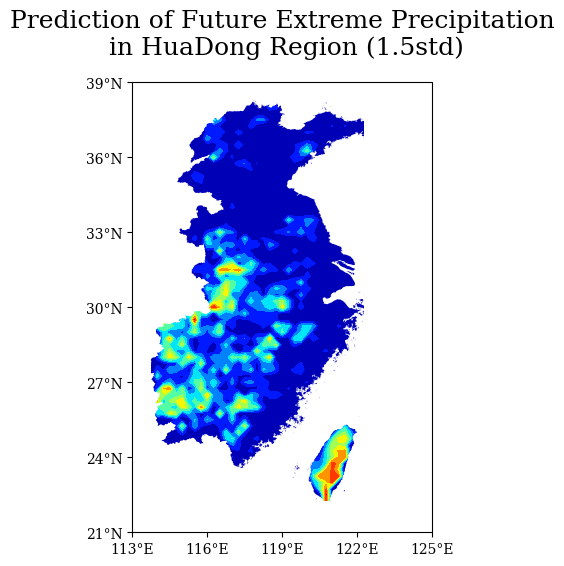

HuaNan ['广东省', '广西壮族自治区', '海南省'] (104, 117, 18, 27)


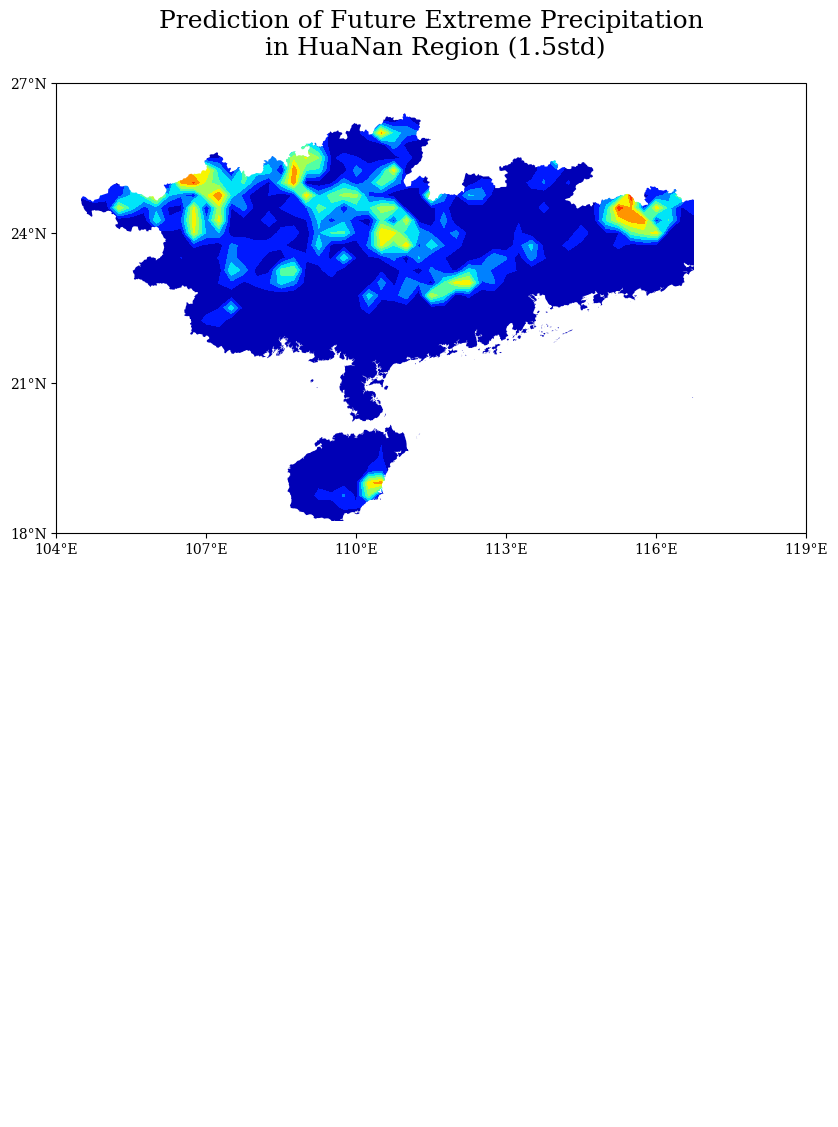

HuaBei ['河北省', '山西省', '北京市', '天津市', '内蒙古自治区'] (97, 126, 33, 54)


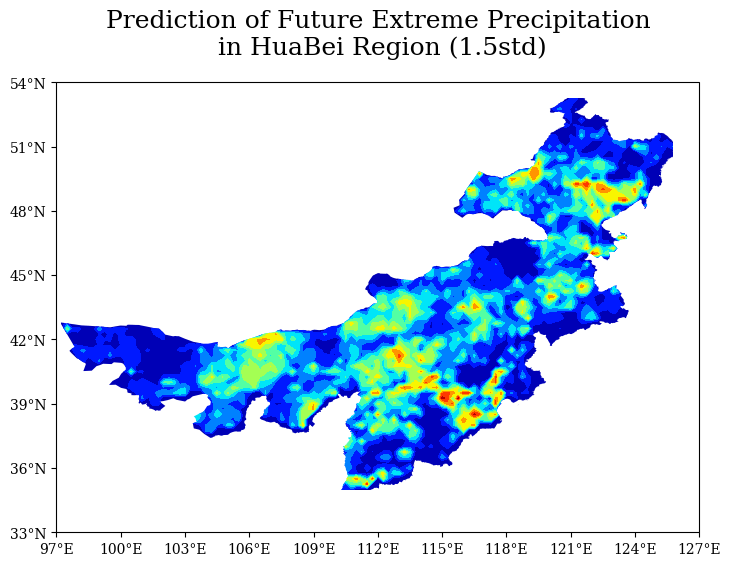

HuaZhong ['湖北省', '湖南省', '河南省'] (108, 117, 23, 38)


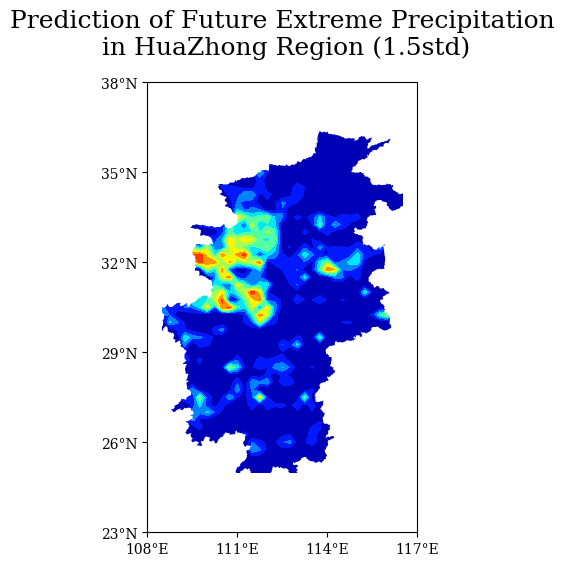

DongBei ['辽宁省', '吉林省', '黑龙江省'] (118, 135, 39, 54)


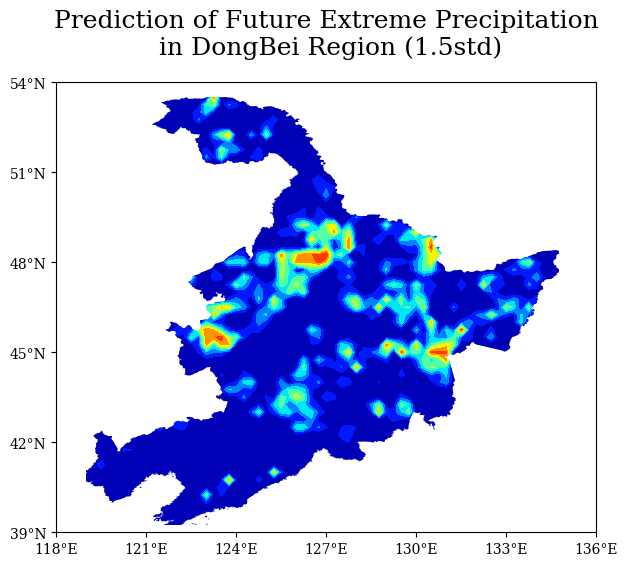

XiNan ['四川省', '云南省', '贵州省', '重庆市', '西藏自治区'] (78, 110, 20, 38)


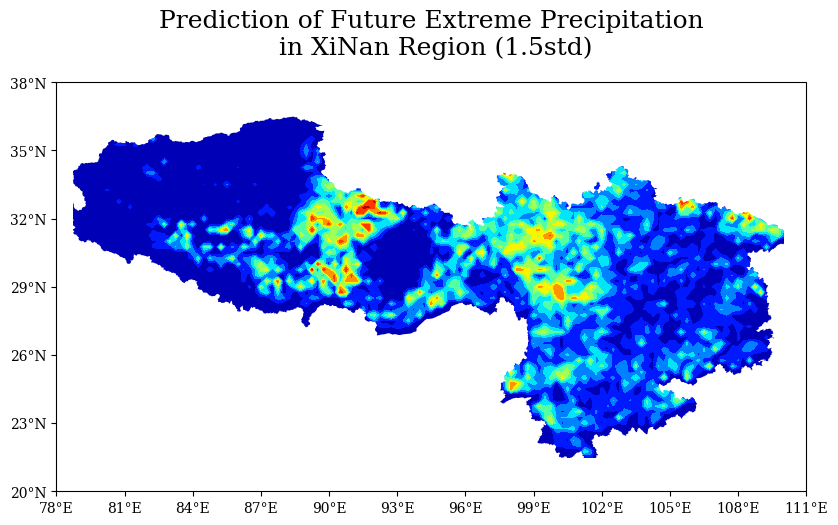

XiBei ['宁夏回族自治区', '新疆维吾尔自治区', '青海省', '陕西省', '甘肃省'] (73, 111, 30, 51)


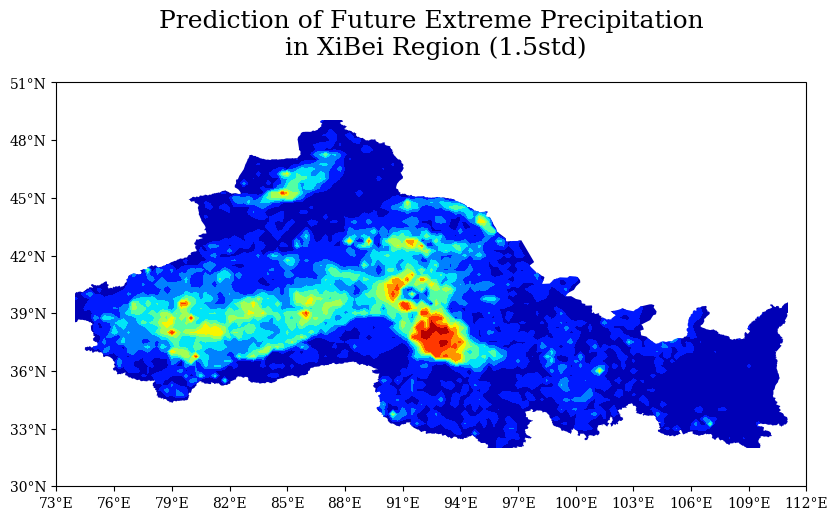

In [9]:
for i,j,k in zip(['HuaDong','HuaNan','HuaBei','HuaZhong','DongBei','XiNan','XiBei'],
               [["江苏省", "浙江省", "安徽省", "福建省", "江西省", "山东省", "上海市", "台湾省"], 
                ["广东省", "广西壮族自治区", "海南省"],
                ["河北省", "山西省", "北京市", "天津市", "内蒙古自治区"],
                ["湖北省", "湖南省", "河南省"],
                ["辽宁省", "吉林省", "黑龙江省"],
                ["四川省", "云南省", "贵州省", "重庆市", "西藏自治区"],
                ["宁夏回族自治区", "新疆维吾尔自治区", "青海省", "陕西省", "甘肃省"]],
               [(113, 123, 21, 39), (104, 117, 18, 27),
                (97, 126, 33, 54), (108, 117, 23, 38), 
                (118, 135, 39, 54), (78, 110, 20, 38),
                (73, 111, 30, 51)]):
    print(i,j,k)
    file = xr.open_dataset('C:/Users/***/Desktop/districts_out/result/1.5std_{}.nc'.format(i)) 
    logistic_values = file.variables['1961-2019 logistic values']    
    data_var = np.nan_to_num(logistic_values)
    data_lat = file.variables['lat']
    data_lon = file.variables['lon']
    # create a canvas
    fig2 = plt.figure(figsize=(15,15))
    proj = ccrs.PlateCarree()#central_longitude=105) 
    leftlon, rightlon, lowerlat, upperlat = tuple(k)
    # plot the map
    f2_ax1 = fig2.add_axes([0.1, 0.1, 0.5, 0.3], projection = proj)
    # create a subplot in absolute coordinates on the canvas
    f2_ax1.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
    ## 10m accuracy coastline
    # f2_ax1.add_feature(cfeature.COASTLINE.with_scale('10m'))
    # define the geo-coordinate tag format
    f2_ax1.set_xticks(np.arange(leftlon,rightlon+3,3), crs=ccrs.PlateCarree())
    f2_ax1.set_yticks(np.arange(lowerlat,upperlat+3,3), crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    lat_formatter = cticker.LatitudeFormatter()
    f2_ax1.xaxis.set_major_formatter(lon_formatter)
    f2_ax1.yaxis.set_major_formatter(lat_formatter)
    f2_ax1.set_title('Prediction of Future Extreme Precipitation\n in {} Region (1.5std)'.format(i),
                     loc='center', pad=20, fontsize=18)
    # read the .shp file
    os.chdir(r'C:\Users\***\Desktop\i.e.re\shpfile\ProvincialBorder')
    china = shpreader.Reader('./bou2_4p.dbf').geometries()
    # fill with contour lines
    lines_level = np.arange(0, 1.1, 0.1)
    data_con = f2_ax1.contourf(data_lon, data_lat, data_var, lines_level, cmap='jet', transform=ccrs.PlateCarree())
    mask_out2.get_maskout().maskout_areas(data_con, f2_ax1,
                    r"C:\Users\***\Desktop\i.e.re\shpfile\ProvincialBorder\bou2_4p.dbf",
                    area_str=j, proj=proj)
    os.chdir(r'C:\Users\***\Desktop\districts_out\resultfig')
    plt.savefig('{}.png'.format(i), dpi=1000, bbox_inches='tight')
    plt.show()